In [1]:
import pickle

import numpy as np
import matplotlib.pyplot as plt
import torch
import random  

import torch
from torch import nn 
from torch.nn import functional as F  
import torchvision
from torchvision import transforms
 
import numpy as np

import matplotlib.pyplot as plt  
 
%matplotlib inline 
torch.manual_seed(0)

### Exploring Metadata

In [2]:
def unpickle(file): 
    
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
file_dict = unpickle(r'cifar-10-batches-py/batches.meta')
label_map = file_dict[ b'label_names']
label_map

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

In [4]:


file_dict = unpickle(r'cifar-10-batches-py/data_batch_1')

rbg_10k_img = file_dict[b'data'] #shape is (10000, 3072) with 
target_var = file_dict[b'labels']
 
assert set(target_var) == set(range(10))
assert rbg_10k_img.shape == (10000, 3072)

In [5]:
'''
rbg_10k_img: Contains rbg of 10k images of file data_batch_{i}   where i in [1,5]
        
        - Has shape (10000, 3072)
        - The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue.

target_var: is the target variable representing the class of the picture  
        - Has shape (10000, 1)
        - The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue.

0: airplane										
1: automobile										
2: bird										
3: cat										
4: deer										
5: dog										
6: frog										
7: horse										
8: ship										
9: truck
'''

def load_train_data():
    rbg_50k_img = []
    class_50k_img = []

    for i in range(5):
        print(f"Loading batch {i+1}...") 

        file_dict = unpickle(f'cifar-10-batches-py/data_batch_{i+1}') 
        rbg_50k_img.append(torch.tensor(file_dict[b'data'], dtype=torch.float32))  
        class_50k_img.append(torch.tensor(file_dict[b'labels'], dtype=torch.long)) 

    
    rbg_50k_img = torch.cat(rbg_50k_img, dim=0)  # Shape: (50000, 3072)
    rbg_50k_img = rbg_50k_img.view(50000, 3, 32, 32)

    class_50k_img = torch.cat(class_50k_img, dim=0)  # Shape: (50000, 1) 
    
    assert set(class_50k_img.tolist()) == set(range(10)), "class_50k_img values are not in the expected range"
    assert rbg_50k_img.shape == torch.Size([50000, 3, 32, 32])
    print("\nTrain set features shape:", rbg_50k_img.shape)    
    print(f"Test set target variable shape: ({len(class_50k_img)},1)") 

    

    return rbg_50k_img, class_50k_img


def load_test_data():
    rbg_10k_img = []
    class_10k_img = []
    print(f"\nLoading test batch...\n") 


    file_dict = unpickle(f'cifar-10-batches-py/test_batch') 
    rbg_10k_img = torch.tensor(file_dict[b'data'], dtype=torch.float32)
    class_10k_img = torch.tensor(file_dict[b'labels'], dtype=torch.long)

    rbg_10k_img = rbg_10k_img.view(10000, 3, 32, 32)  

    assert set(class_10k_img.tolist()) == set(range(10)), "class_10k_img values are not in the expected range"
    assert rbg_10k_img.shape == torch.Size([10000, 3, 32, 32])
    print("Test set features shape:", rbg_10k_img.shape)   
    print(f"Test set target variable shape: ({len(class_10k_img)},1)") 

    return rbg_10k_img, class_10k_img


X_train, Y_train = load_train_data()
X_test, Y_test = load_test_data()

Loading batch 1...
Loading batch 2...
Loading batch 3...
Loading batch 4...
Loading batch 5...

Train set features shape: torch.Size([50000, 3, 32, 32])
Test set target variable shape: (50000,1)

Loading test batch...

Test set features shape: torch.Size([10000, 3, 32, 32])
Test set target variable shape: (10000,1)


In [36]:
def load_data_cifar10(batch_size, resize=None, shuffle_train = False):
    """Download the CIFAR-10 dataset and then load it into memory."""
    
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)

    # Download and create datasets
    cifar10_train = torchvision.datasets.CIFAR10(
        root="../data", train=True, transform=trans, download=True)
    cifar10_test = torchvision.datasets.CIFAR10(
        root="../data", train=False, transform=trans, download=True)

    # Create data loaders
    train_iter = torch.utils.data.DataLoader(
        cifar10_train, batch_size=batch_size, shuffle= shuffle_train, num_workers=2)
    test_iter = torch.utils.data.DataLoader(
        cifar10_test, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_iter, test_iter


batch_size = 10000
train_iter, test_iter = load_data_cifar10(batch_size, resize=None)

for x_train , y_train in train_iter:
    print("Batch X shape:", x_train.shape)
    print("Batch y shape:", y_train.shape)
    break

for x_test , y_test in test_iter:
    print("Batch X shape:", x_test.shape)
    print("Batch y shape:", y_test.shape)
    break



Files already downloaded and verified
Files already downloaded and verified
Batch X shape: torch.Size([10000, 3, 32, 32])
Batch y shape: torch.Size([10000])
Batch X shape: torch.Size([10000, 3, 32, 32])
Batch y shape: torch.Size([10000])


In [7]:
if (X_train[0:10000] == 255 * x_train).all() and ( X_test[0:10000] == 255 * x_test).all():
    print(f' This way IS EXACTLY the same as the above cell') 

 This way IS EXACTLY the same as the above cell


### Checking out a random picture with its associated tag

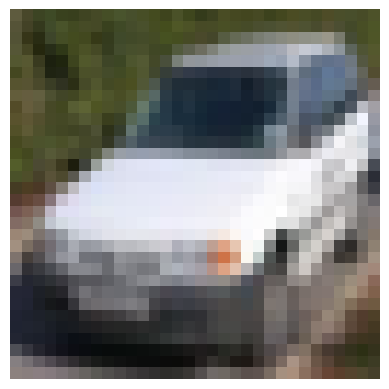

This is a b'automobile' 


In [8]:
img_no = random.randint(0, 10000)
img_no = 46

# Assuming `rbg_50k_img` is a PyTorch tensor of shape (50000, 3, 32, 32)
img = 255 * x_train[img_no]  # Select first image

# Convert from Tensor to NumPy for plotting
img = img.permute(1, 2, 0).numpy()  # Change shape from (3, 32, 32) -> (32, 32, 3)

# Display the image
plt.imshow(img.astype("uint8"))
plt.axis("off")  # Hide axis
plt.show()
print( f'This is a {label_map[int(y_train[img_no])]} ')

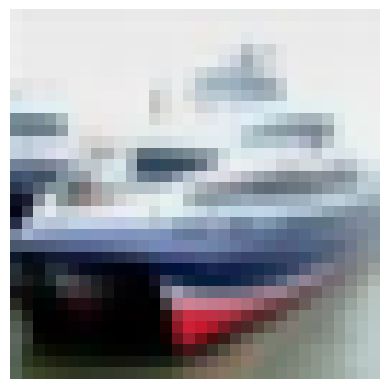

This is a b'ship' 


In [9]:
img_no = random.randint(0, 10000)
img_no = 1
# Assuming `rbg_50k_img` is a PyTorch tensor of shape (50000, 3, 32, 32)
img = 255 * x_test[img_no]  # Select first image

# Convert from Tensor to NumPy for plotting
img = img.permute(1, 2, 0).numpy()  # Change shape from (3, 32, 32) -> (32, 32, 3)

# Display the image
plt.imshow(img.astype("uint8"))
plt.axis("off")  # Hide axis
plt.show()
print( f'This is a {label_map[int(y_test[img_no])]} ')

In [61]:
torch.manual_seed(1)

class InterBlock(nn.Module):
    def __init__(self, x, device, num_convolutions, num_out_fc_layers):
        super(InterBlock, self).__init__() 
        
        self.batch_size = x.shape[0]
        self.device = device  
        self.num_out_fc_layers = num_out_fc_layers
        self.num_convolutions = num_convolutions
        self.num_channels = 3
        
        self.Batch1 = nn.ModuleList([
                            nn.Conv2d(in_channels=3, out_channels= 11, kernel_size=3, stride=1, padding=1)  
                            for _ in range(num_convolutions)
                ]).to(self.device)
        
        self.compute_m = nn.AdaptiveAvgPool2d((1, 1)).to(self.device)  ### Check that this is the same as the mean per channel

        self.a_Batch1 = nn.Linear(in_features= self.num_channels, out_features= self.num_convolutions).to(self.device)
        self.Relu = nn.ReLU()   #OPTIONAL?!
        self.fc_out_layers = nn.ModuleList([
                            nn.Linear(in_features=32 , out_features=10) 
                            for _ in range(num_out_fc_layers)
                   ]).to(self.device)

    
    def compute_out(self, x):
        m = torch.mean(torch.mean(x, dim=1), dim=1)
        m = m.to(self.device)  # Move `m` to the correct device
        
        out = torch.zeros( [self.batch_size, 10], device=self.device)  # Ensure `out` is also on GPU if needed
        for dense in self.fc_out_layers:
            out += dense(m)

        return out / self.num_out_fc_layers  # Normalize output


    
    def forward(self, x):    
        x = x.to(device)
        
        # Computing a
        a = self.compute_m( x ).reshape([self.batch_size, self.num_channels])
        print(f'a has shape {a.shape} before the FCL')
        a = self.a_Batch1(a).to(self.device)
        print(f'a has shape {a.shape} after the FCL')
             
        out = torch.zeros(self.batch_size, 11, 32, 32).to(self.device)
        #Computing the convolutions
        conv_outputs = []
        for conv in self.Batch1:
            conv_outputs.append( self.Relu(conv(x.to(self.device)))  # each output has shape (batch_size, 11, 32, 32)
        # 2. Stack them into a single tensor of shape (batch_size, num_convs, 11, 32, 32)
        #    i.e. we insert a new dimension at dim=1 to hold the "num_convs" dimension.
        conv_outputs_stacked = torch.stack(conv_outputs, dim=1).to(self.device)
        # 3. Reshape 'a' to broadcast across the (11, 32, 32) dimensions.
        #    Now 'a' will have shape (batch_size, num_convs, 1, 1, 1).
        a = a.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).to(self.device)
        print(f'a has now has shape {a.shape}')
        # 4. Multiply and sum along the 'num_convs' dimension (dim=1).
        out = (conv_outputs_stacked * a).sum(dim=1)
            
        out = self.Relu(out)
        out = self.compute_out(out)
        
        return out  


device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

model = InterBlock(x_train, device, num_convolutions=2, num_out_fc_layers=1).to(device)
output = model.forward(x_train)

print(output.shape)

a has shape torch.Size([1000, 3]) before the FCL
a has shape torch.Size([1000, 2]) after the FCL
a has now has shape torch.Size([1000, 2, 1, 1, 1])
torch.Size([1000, 10])


In [ ]:
def cross_entropy_loss(logit, label): 
    criterion = nn.CrossEntropyLoss()  
    loss = criterion(logit, label)
    
    return loss

def evaluate_metric(model, data_iter, metric, device):
    """Compute the average `metric` of the model on a dataset.""" 
    c = torch.tensor(0.).to(device)
    n = torch.tensor(0.).to(device)
    model = model.to(device)
    print(model)
    for X, y in data_iter: 
        logits = model(X).to(device)
        c += metric(logits, y.to(device)).to(device)
        n += len(y)  
    return c / n

def correct(logits, y):
    y_hat = logits.argmax(axis=1).to(device) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.


In [53]:
batch_size = 1000
train_iter, test_iter = load_data_cifar10(batch_size, resize=None, shuffle_train = False)

for x_train , y_train in train_iter:
    print("Batch X shape:", x_train.shape)
    print("Batch y shape:", y_train.shape)
    break

for x_test , y_test in test_iter:
    print("Batch X shape:", x_test.shape)
    print("Batch y shape:", y_test.shape)
    break


Files already downloaded and verified
Files already downloaded and verified
Batch X shape: torch.Size([1000, 3, 32, 32])
Batch y shape: torch.Size([1000])
Batch X shape: torch.Size([1000, 3, 32, 32])
Batch y shape: torch.Size([1000])


In [62]:
losses = [] # Stores the loss for each training batch
train_accs = [] # Stores the training accuracy after each epoch
test_accs = [] # Stores the testing accuracy after each epoch

lr = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=lr)  

model = InterBlock(x_train, device, num_convolutions=4, num_out_fc_layers=1).to(device)
num_epochs = 20

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}.')
    
    for x_train, y_train in train_iter: 
        logits = model(x_train).to(device) 
        l = cross_entropy_loss(logits , y_train.to(device)).to(device) # Computes the loss given the `logits` and the class vector `y`
        optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
        l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

        optimizer.step() # Updates the model parameters based on the gradients stored inside them
        print(f'Loss: {float(l)}')
        losses.append(float(l)) # Stores the loss for this batch
    print(evaluate_metric(model, train_iter , correct, device))
       
    with torch.no_grad(): # Computing performance metrics does not require gradients
        train_accs.append( evaluate_metric(model, train_iter , correct, device)  ) 
        test_accs.append( evaluate_metric(model, test_iter, correct, device) ) 
        print(f'Training accuracy: {train_accs[-1]}. Testing accuracy: {test_accs[-1]}.')


Epoch 1/20.
a has shape torch.Size([1000, 3]) before the FCL
a has shape torch.Size([1000, 4]) after the FCL
a has now has shape torch.Size([1000, 4, 1, 1, 1])
Loss: 2.3048079013824463
a has shape torch.Size([1000, 3]) before the FCL
a has shape torch.Size([1000, 4]) after the FCL
a has now has shape torch.Size([1000, 4, 1, 1, 1])
Loss: 2.3039188385009766
a has shape torch.Size([1000, 3]) before the FCL
a has shape torch.Size([1000, 4]) after the FCL
a has now has shape torch.Size([1000, 4, 1, 1, 1])
Loss: 2.3048460483551025
a has shape torch.Size([1000, 3]) before the FCL
a has shape torch.Size([1000, 4]) after the FCL
a has now has shape torch.Size([1000, 4, 1, 1, 1])
Loss: 2.3024911880493164
a has shape torch.Size([1000, 3]) before the FCL
a has shape torch.Size([1000, 4]) after the FCL
a has now has shape torch.Size([1000, 4, 1, 1, 1])
Loss: 2.304943561553955
a has shape torch.Size([1000, 3]) before the FCL
a has shape torch.Size([1000, 4]) after the FCL
a has now has shape torch.

KeyboardInterrupt: 

In [ ]:
x_test.shape , x_train.shape

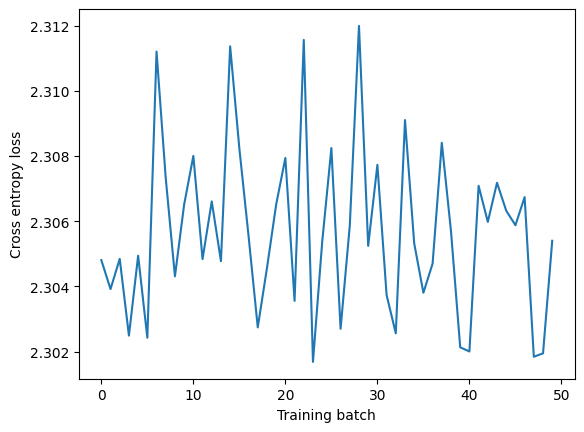

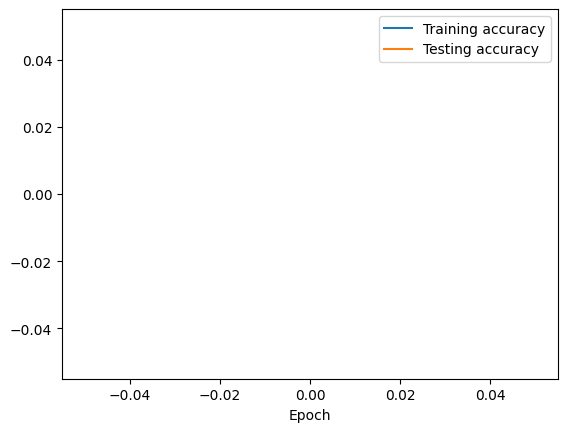

In [63]:
plt.plot(losses) # Plots the loss for each training batch
plt.xlabel('Training batch')
plt.ylabel('Cross entropy loss')
plt.show()

plt.plot(train_accs, label='Training accuracy')
plt.plot(test_accs, label='Testing accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.show()

In [51]:
train_accs

[tensor(0.1006, device='cuda:0'),
 tensor(0.1006, device='cuda:0'),
 tensor(0.1006, device='cuda:0'),
 tensor(0.1006, device='cuda:0'),
 tensor(0.1006, device='cuda:0'),
 tensor(0.1006, device='cuda:0'),
 tensor(0.1006, device='cuda:0'),
 tensor(0.1006, device='cuda:0'),
 tensor(0.1006, device='cuda:0'),
 tensor(0.1006, device='cuda:0'),
 tensor(0.1006, device='cuda:0'),
 tensor(0.1006, device='cuda:0')]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 5000
x = x_train[0:batch_size].to(device)
print(x.shape)
y = torch.tensor(y_train[0:batch_size]).to(device)

lr = 0.7
iterations = 3

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
 
 
def init_weights(m):
    if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)

model =  NeuralNet(device, num_convolutions= 4, num_out_fc_layers= 1)
# model.apply(init_weights) # Applies `init_weights` to every `torch.nn.Module` inside `model`


model.to('cuda')
errors = []
losses = []

for ep in range(iterations):
  print(f'Iteration: {ep}')
  error_sum = 0
  for i in range(x.shape[0]):
 
    y_pred = model.forward(x[i])
      
    error = cross_entropy_loss( logit= y_pred, label= y[i])
    error_sum += error  
    
    optimizer.zero_grad()
    error.backward()

    optimizer.step()
    losses.append(error)

  errors.append( float(error_sum/x.shape[0]) )


In [ ]:
# [x.item() for x in errors]
errors


In [ ]:
plt.plot(list(range(iterations)), errors)
plt.show()

y_pred = torch.zeros_like(y)
for i in range(x.shape[1]):
  y_pred[i] = model(x[i])[1]
print(y, y_pred)